# Import & show data

In [3]:
!pip install bs4==0.0.1

  Using cached bs4-0.0.1.tar.gz (1.1 kB)
     |████████████████████████████████| 115 kB 27.9 MB/s 
  Created wheel for bs4: filename=bs4-0.0.1-py3-none-any.whl size=1273 sha256=7eca9766c4525fc1a9ffa4df718286307cd00fc707d79e78cbd295d6fe37697a
  Stored in directory: /root/.cache/pip/wheels/0a/9e/ba/20e5bbc1afef3a491f0b3bb74d508f99403aabe76eda2167ca
Successfully built bs4
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [5]:
!pip install gensim==3.8.3

  Using cached gensim-3.8.3-cp37-cp37m-manylinux1_x86_64.whl (24.2 MB)
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [6]:
import pandas as pd
import numpy as np
import bs4
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
import gensim
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from gensim.models import FastText
from gensim.models import TfidfModel
from gensim.corpora import Dictionary
from sklearn.neighbors import NearestNeighbors

In [7]:
df = pd.read_csv('../data/Questions.csv', encoding = "ISO-8859-1", nrows=30000, usecols=['Id', 'Title'])
df.shape

(30000, 2)

In [12]:
#Let's take a look at some of the questions
print('Question1: ', df.iloc[0, 1])
print('Question2: ', df.iloc[1, 1])
print('Question3: ', df.iloc[2, 1])

Question1:  How can I find the full path to a font from its display name on a Mac?
Question2:  Get a preview JPEG of a PDF on Windows?
Question3:  Continuous Integration System for a Python Codebase


# Preprocessing

In [14]:
#Using beautiful soup to grab text inside 'p' tags and concatenate it
def get_question(html_text):
  soup = BeautifulSoup(html_text, 'lxml')
  question = ' '.join([t.text for t in soup.find_all('p')]) #concatenating all p tags
  return question

#Transforming questions to list for ease of processing
question_list = df['Title'].apply(get_question).values.tolist()

In [15]:
question_list[0]

'How can I find the full path to a font from its display name on a Mac?'

In [16]:
#Tokenizing with simple preprocess gensim's simple preprocess
def sent_to_words(sentences):
    for sentence in sentences:
        yield(simple_preprocess(str(sentence), deacc=True)) # returns lowercase tokens, ignoring tokens that are too short or too long

question_words = list(sent_to_words(question_list))

In [17]:
question_words[0][0:10] #first 10 questions tokens

['how', 'can', 'find', 'the', 'full', 'path', 'to', 'font', 'from', 'its']

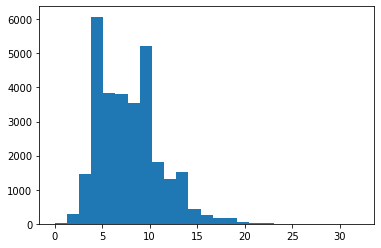

Mean word count of questions is 7.8223


In [18]:
lengths = [len(question) for question in question_words]
plt.hist(lengths, bins = 25)
plt.show()

print('Mean word count of questions is %s' % np.mean(lengths))

In [19]:
#Getting rid of stopwords
nltk.download('stopwords')
stop_words = stopwords.words('english')

def remove_stopwords(sentence):
  filtered_words = [word for word in sentence if word not in stop_words]
  return filtered_words

filtered_questions = [remove_stopwords(question) for question in question_words]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


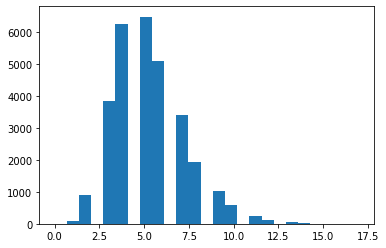

Mean word count of questions is 5.3517


In [20]:
#Examining word counts after removal of stop words

lengths = [len(question) for question in filtered_questions]
plt.hist(lengths, bins = 25)
plt.show()

print('Mean word count of questions is %s' % np.mean(lengths))

In [21]:
len(filtered_questions)

30000

# Word2Vec

In [22]:
#Instantiating the model
n = 50
model = Word2Vec(filtered_questions, size = n, window = 8)

#Training model using questions corpora
model.train(filtered_questions, total_examples=len(filtered_questions), epochs=10)

(1235034, 1605510)

In [23]:
#Let's see how it worked
word_vectors = model.wv

print('Words similar to "array" are: ', word_vectors.most_similar(positive='array'))
print('Words similar to "database" are: ', word_vectors.most_similar(positive='database'))

Words similar to "array" are:  [('arrays', 0.9218310117721558), ('matrix', 0.9211524724960327), ('dimensional', 0.8458638787269592), ('recarray', 0.8443092703819275), ('numpy', 0.8217630982398987), ('vector', 0.8003685474395752), ('matrices', 0.7973954081535339), ('sparse', 0.7892090082168579), ('nan', 0.7802515029907227), ('operations', 0.7783718109130859)]
Words similar to "database" are:  [('sqlite', 0.8504010438919067), ('sql', 0.8144783973693848), ('stored', 0.7601233720779419), ('db', 0.7546879649162292), ('postgresql', 0.7515819072723389), ('tables', 0.7464178204536438), ('insert', 0.7411580681800842), ('mysql', 0.7378960847854614), ('dump', 0.7288544178009033), ('table', 0.7268080711364746)]


# Fast Text

In [24]:
ft_model = FastText(filtered_questions, size=n, window=8, min_count=5, workers=2,sg=1)

In [25]:
print('Words similar to "array" are: ', ft_model.wv.most_similar('array'))
print('Words similar to "database" are: ', ft_model.wv.most_similar('database'))

Words similar to "array" are:  [('arrays', 0.9918513894081116), ('ndarray', 0.985777735710144), ('numpy', 0.9747053384780884), ('matrix', 0.9477270245552063), ('recarray', 0.946686863899231), ('matrices', 0.9455903172492981), ('slices', 0.9215148687362671), ('slice', 0.915821373462677), ('two', 0.9136978983879089), ('indices', 0.9110772609710693)]
Words similar to "database" are:  [('databases', 0.9929320812225342), ('dataset', 0.9242563843727112), ('jquery', 0.9200167059898376), ('sqlite', 0.9177411794662476), ('datasets', 0.9104514122009277), ('queries', 0.9094953536987305), ('gqlquery', 0.9049663543701172), ('query', 0.9011733531951904), ('gql', 0.9005076289176941), ('updates', 0.8990510702133179)]


## TF-IDF

In [26]:
dct = Dictionary(filtered_questions)  # fit dictionary
corpus = [dct.doc2bow(line) for line in filtered_questions]  # convert corpus to BoW format
tfidf_model = TfidfModel(corpus)  # fit model

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(question_list)
print(X.shape)

(30000, 11987)


In [28]:
#To proprely work with scikit's vectorizer
merged_questions = [' '.join(question) for question in filtered_questions]
document_names = ['Doc {:d}'.format(i) for i in range(len(merged_questions))]

def get_tfidf(docs, ngram_range=(1,1), index=None):
    vect = TfidfVectorizer(stop_words='english', ngram_range=ngram_range)
    tfidf = vect.fit_transform(docs).todense()
    return pd.DataFrame(tfidf, columns=vect.get_feature_names(), index=index).T

tfidf = get_tfidf(merged_questions, ngram_range=(1,1), index=document_names)

In [29]:
def get_sent_embs(emb_model):
    sent_embs = []
    for desc in range(len(filtered_questions)):
        sent_emb = np.zeros((1, n))
        if len(filtered_questions[desc]) > 0:
            sent_emb = np.zeros((1, n))
            div = 0
            model = emb_model
            for word in filtered_questions[desc]:
                if word in model.wv.vocab and word in tfidf.index:
                    word_emb = model.wv[word]
                    weight = tfidf.loc[word, 'Doc {:d}'.format(desc)]
                    sent_emb = np.add(sent_emb, word_emb * weight)
                    div += weight
                else:
                    div += 1e-13 #to avoid dividing by 0
        if div == 0:
            print(desc)

        sent_emb = np.divide(sent_emb, div)
        sent_embs.append(sent_emb.flatten())
    return sent_embs

In [30]:
ft_sent = get_sent_embs(emb_model = ft_model) 

## Finding Similar Questions

In [31]:
def get_n_most_similar(interest_index, embeddings, n):
    """
    Takes the embedding vector of interest, the list with all embeddings, and the number of similar questions to 
    retrieve.
    Outputs the disctionary IDs and distances
    """
    nbrs = NearestNeighbors(n_neighbors=n, metric='cosine').fit(embeddings)
    distances, indices = nbrs.kneighbors(embeddings)
    similar_indices = indices[interest_index][1:]
    similar_distances = distances[interest_index][1:]
    return similar_indices, similar_distances

def print_similar(interest_index, embeddings, n):
    """
    Convenience function for visual analysis
    """
    closest_ind, closest_dist = get_n_most_similar(interest_index, embeddings, n)
    print('Question %s \n \n is most similar to these %s questions: \n' % (question_list[interest_index], n))
    for question in closest_ind:
        print('ID ', question, ': ',question_list[question])

In [32]:
print_similar(42, ft_sent, 5)

Question Sanitising user input using Python 
 
 is most similar to these 5 questions: 

ID  28113 :  python: getting user input
ID  10185 :  Reading HKEY CURRENT USER from the registry in Python, specifying the user
ID  27298 :  Using if/elif/else and resp=raw_input - how to respond to part of a user's input?
ID  15506 :  Is it possible to make user input invisible as a 'sudo' password input?


## Doc2Vec

In [33]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(filtered_questions)]
model = Doc2Vec(documents, vector_size=n, window=8, min_count=5, workers=2, dm = 1, epochs=20)

In [34]:
print(question_list[42], ' \nis similar to \n')
print([question_list[similar[0]] for similar in model.docvecs.most_similar(42)])

Sanitising user input using Python  
is similar to 

['Urlretrieve and User-Agent? - Python', 'Stealing Cookies with no user input?', 'Python web devlopment framework for python 3.1 user', 'pyinotify file deletion user', 'Using Javascript to change all textareas in an html page', 'Python - checking if a user has administrator privileges', "How to save user's daily progress?", 'How can I have an encrypted input in Python?', 'Django admin - Restrict user view by permission', 'Redirecting a user in a django template']


In [35]:
print_similar(90, ft_sent, 5)

Question How do I make Windows aware of a service I have written in Python? 
 
 is most similar to these 5 questions: 

ID  2500 :  Create a cross-platform protocol helper that runs a python script
ID  18375 :  Crontab job does not start... ideas?
ID  15854 :  Python web frontend, retaining interpreter state
ID  16463 :  Linux development/minimal smtp and pop3 server


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=3c29a683-71a2-405c-b0ad-9e789f7cae87' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>